# 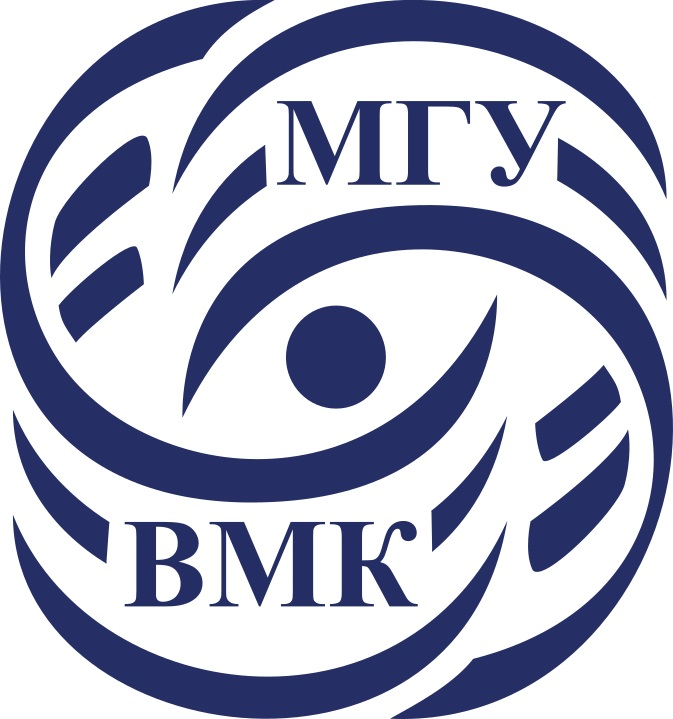

# Машинное обучение. ВМК МГУ

## Практическое задание 6: SVM

### Важно! О формате сдачи

* Практически все задания в этой части оцениваются по системе <font color='red'>кросс-рецензирования.</font>
* В этом задании есть <font color="red">новый тип задания -- ML-решение</font>
* При решении ноутбука <font color='red'>используйте данный шаблон.</font> Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно
* Везде, где в формулировке задания есть <font color='red'>какой-либо вопрос (или просьба вывода)</font>, необходимо прописать ответ в ячейку (код или markdown).
* Наличие <font color='red'>кода решения обязательно.</font> Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.
* Если в ячейке написана фраза <font color='red'>"Вывод"/"Ответ на вопрос" итд</font>, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано <font color='red'>"Your code here" и пр. </font>, то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст

Цель данного задания:

* Изучите работу модели SVM
* Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
* Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)
* Узнаете про метод, который позволяет понижать число признаков и изучите его особенности на практике
* Научитесь корректировать выход модели SVM-классификатора, чтобы уметь получать вероятности

### <font color=orange>*Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: не более 10 минут (без учета ML-задачи)</font>*

## Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

**Важно!**
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Важно!**
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-23-24/blob/main/tutorials/Туториал%20по%20установке%20рабочего%20окружения%20в%20Python%20для%20решения%20задач.pdf)

In [ ]:
! gdown 1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199
! pip install -r /content/requirements_small.txt

In [ ]:
import catboost
assert(catboost.__version__ == '1.2.2')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2023"></font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

In [ ]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [ ]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()

def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(loc=1.0, size=(size1, 2)),
        np.random.normal(loc=0.5, size=(size2, 2))
    )]

    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [ ]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1],
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

#### Загрузим данные для задания, их же вы можете найти в cv-gml

In [ ]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1bp39_Jj0edo1lzxZ3DIoChsOVy5DVi1R?usp=sharing')

# 1. Разделяющая поверхность (1 балл)

В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.
    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью ${sklearn.svm.SVC(kernel='linear')}$, а также нелинейную c rbf-ядром с помощью ${sklearn.svm.SVC(kernel='rbf')}$. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [ ]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

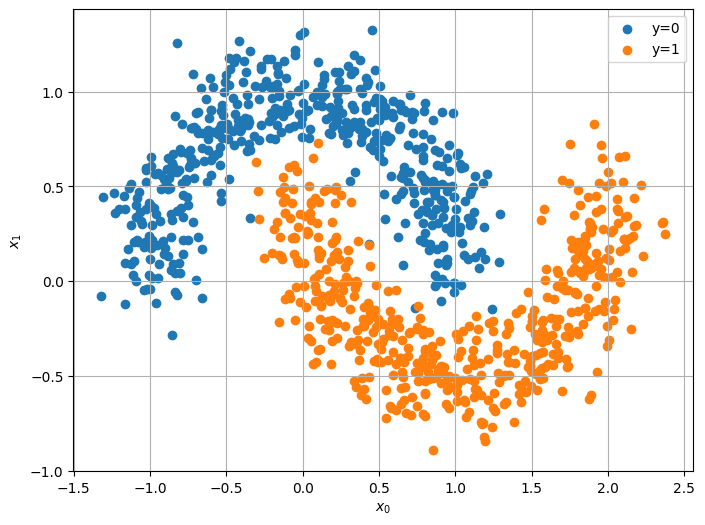

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

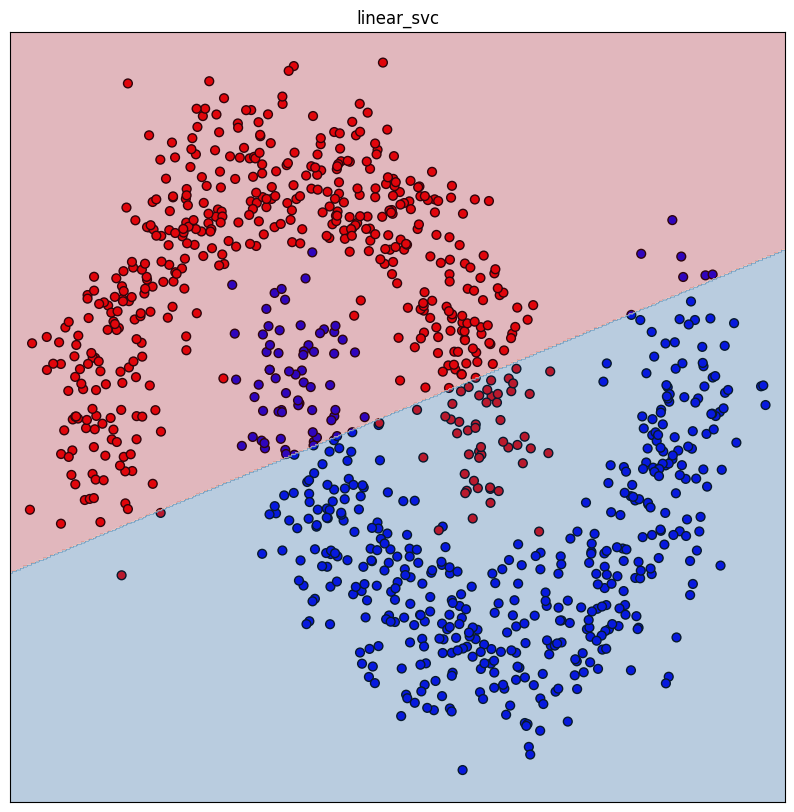

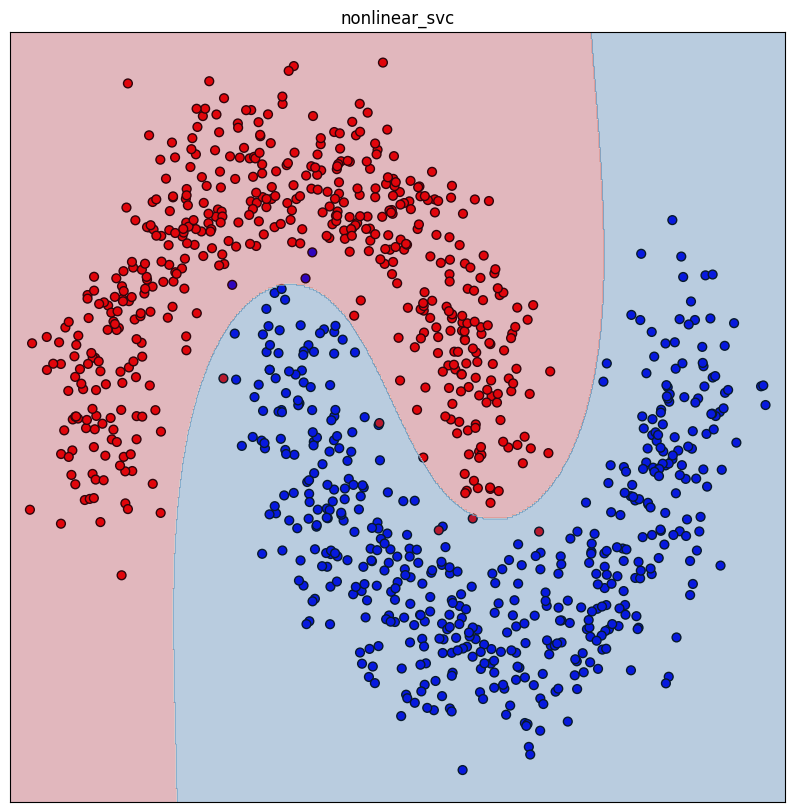

Train Accuracy (linear): 0.877
Train Accuracy (non linear): 0.992


In [ ]:
linear_svc.fit(X, y)
nonlinear_svc.fit(X, y)

plot_separating_surface(X, y, linear_svc, title='linear_svc')
plot_separating_surface(X, y, nonlinear_svc, title='nonlinear_svc')

print(f'Train Accuracy (linear): {accuracy_score(y, linear_svc.predict(X)):.3f}')
print(f'Train Accuracy (non linear): {accuracy_score(y, nonlinear_svc.predict(X)):.3f}')

**Сделайте вывод**
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему?

**Вывод:** Для данной выборки лучше подходит модель nonlinear_svc, так как ядро RBF лучше справляется с нелинейностью данных. Это заметно по показаниям accuracy, а так же по графикам: в центральной части разделение с помощью RBF проходит более аккуратно и точно, нежели линейная модель, которая отсекает в неправильный класс большое количество объектов выборки.

# 2. Опорные объекты (2 балла)

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достанем опорные объекты из обученной модели с помощью поля model.support_.

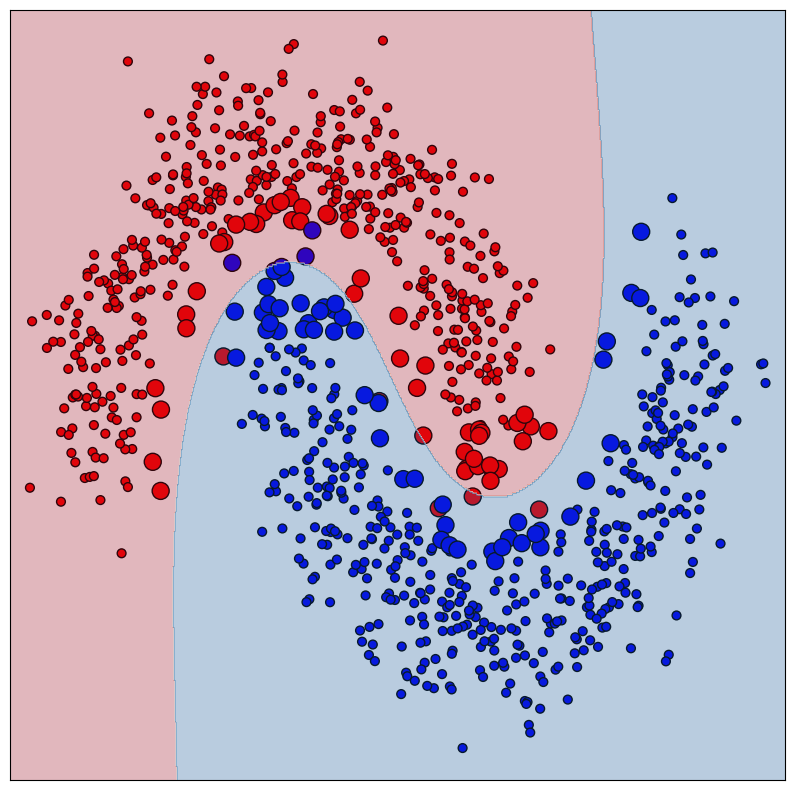

In [ ]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

**Пункт 1**
Обучим новые две модели ${SVC(kernel='rbf')}$, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [ ]:
# Учим модели только на опорных объектах
svc_on_linear_support = SVC(kernel='rbf').fit(X[linear_svc.support_, :], y[linear_svc.support_])
svc_on_rbf_support = SVC(kernel='rbf').fit(X[nonlinear_svc.support_, :], y[nonlinear_svc.support_])

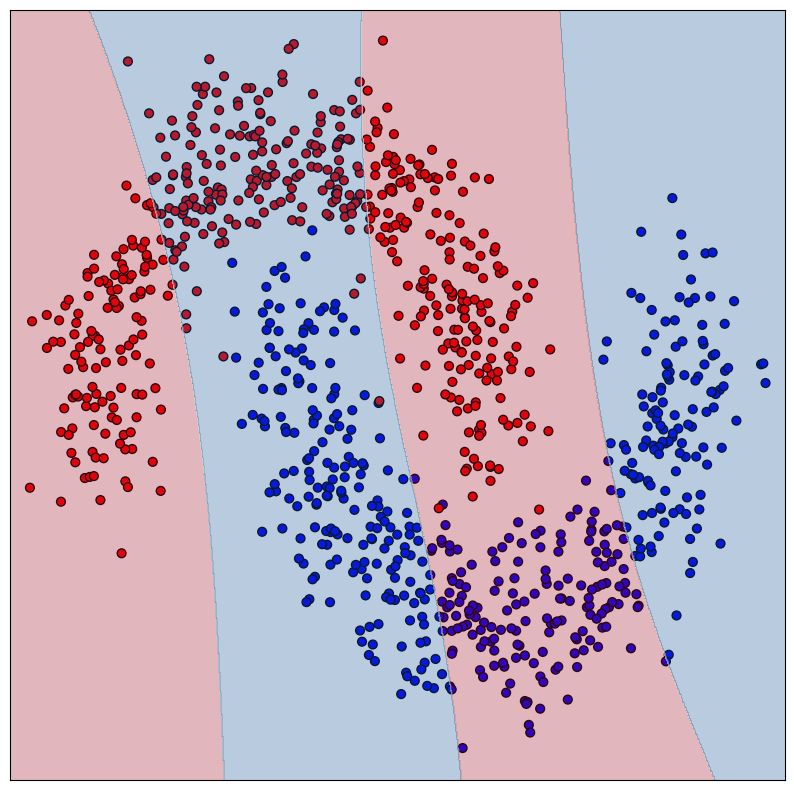

In [ ]:
plot_separating_surface(X, y, svc_on_linear_support)

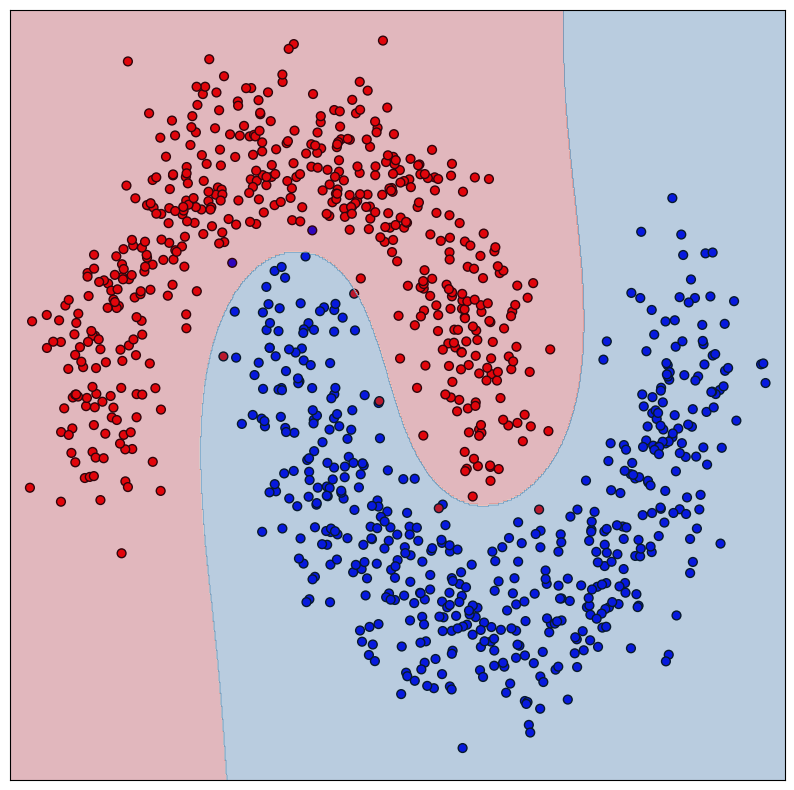

In [ ]:
plot_separating_surface(X, y, svc_on_rbf_support)

**Задание:** Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из первой части. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе.

**Вывод:** Разделяющая поверхность, обученная на опорных объектах нелинейной модели, больше похожа на нелинейную модель из первой части, так как она способна эффективнее моделировать сложные границы между классами. Это говорит о том, что использование опорных объектов из нелинейной модели дает лучший результат при использовании ядра RBF, так как они содержат более релевантную информацию о структуре данных.

**Пункт 2** Обучим модель ${SVC(kernel='rbf')}$, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравним эту модель вместе с svc_on_rbf_support с нелинейной моделью из первой части (nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [ ]:
non_support_vectors = [i for i in range(len(X)) if i not in nonlinear_svc.support_]
svc_all_without_rbf_support = SVC(kernel='rbf').fit(X[non_support_vectors, :], y[non_support_vectors])

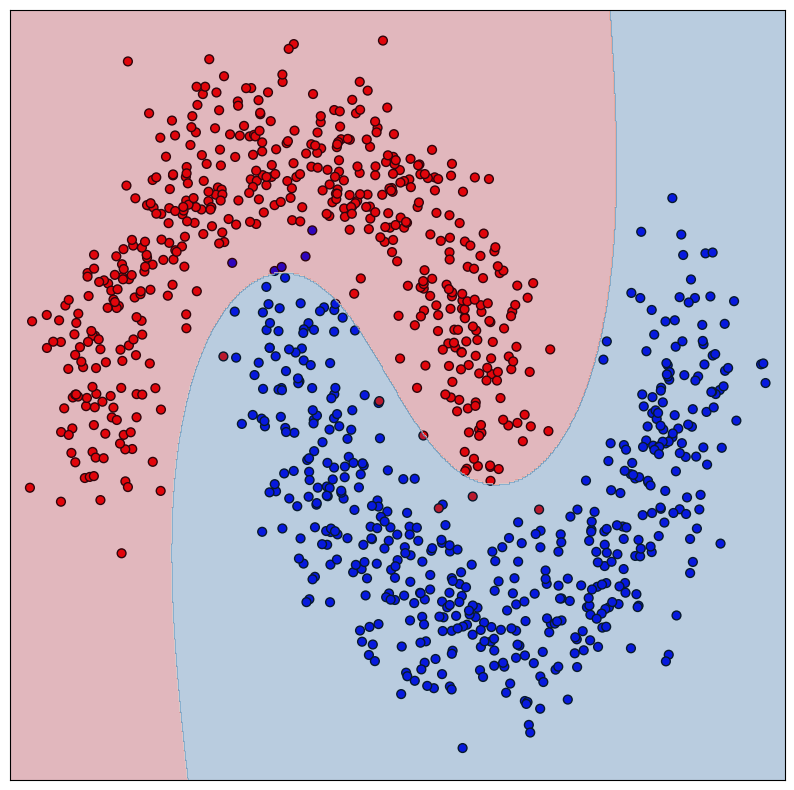

In [ ]:
plot_separating_surface(X, y, svc_all_without_rbf_support)

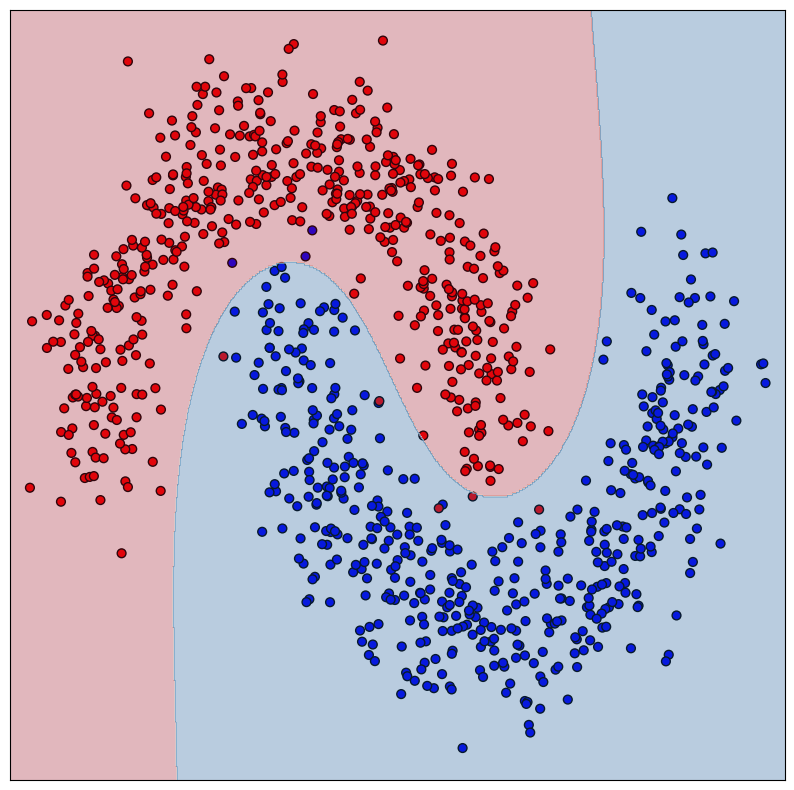

In [ ]:
plot_separating_surface(X, y, nonlinear_svc)

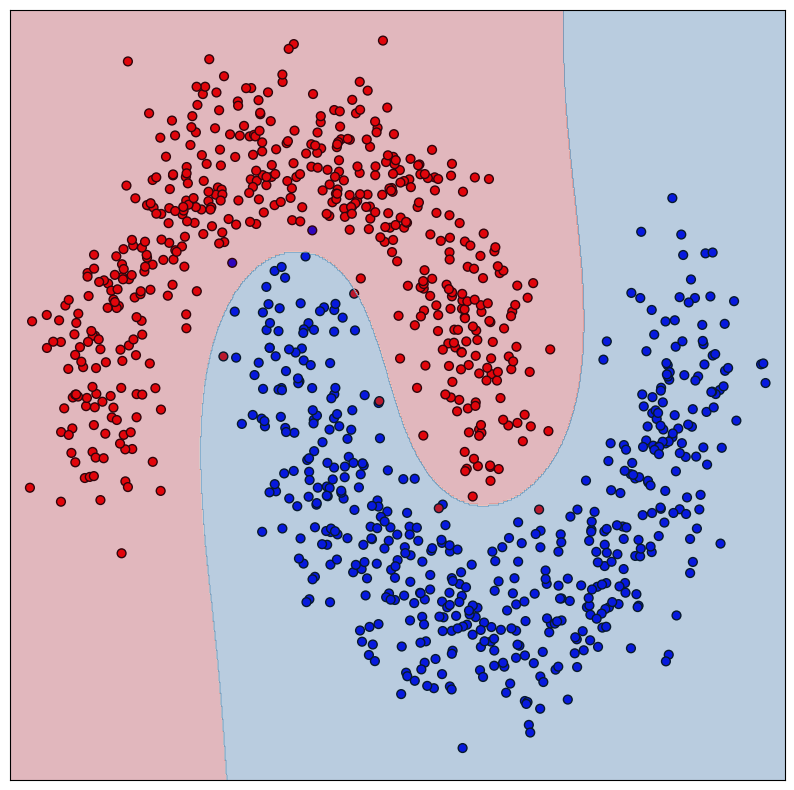

In [ ]:
plot_separating_surface(X, y, svc_on_rbf_support)

**Сделайте вывод:** Сильно ли полученные поверхности отличаются от той, что была получена в первой части? Что произошло с пограничными объектами? Объясните полученные результаты.

**Вывод:**

1. На первом изображении представлена модель, обученная на всех объектах, за исключением тех, которые являются опорными. Эта модель показывает разделяющую поверхность, которая не полностью учитывает границы между классами данных, что приводит к смешению классов в пограничных областях. Это говорит о том, что опорные объекты имеют критическое значение для корректного построения разделяющей поверхности в нелинейных моделях, так как они определяют границы решения.

2. На втором изображении показана нелинейная модель из первой части, которая демонстрирует хорошее разделение между классами данных с помощью гладкой и четко определенной границы.

3. На третьем изображении представлена модель, обученная только на опорных объектах. Наблюдается, что разделяющая поверхность очень похожа на поверхность нелинейной модели из второго изображения, что подчеркивает важность опорных объектов для определения разделяющей поверхности. Модель, обученная на опорных объектах, смогла воспроизвести границу между классами с высокой степенью точности, даже не используя все доступные данные.

Полученные результаты подтверждают, что опорные объекты являются ключевыми элементами в построении разделяющей поверхности для нелинейных SVM. Они обеспечивают необходимую информацию для определения формы границы, и даже при отсутствии остальных данных, модель может точно классифицировать объекты. Как видим, удаление неопорных объектов не влияет значительно на форму разделяющей поверхности, что говорит о том, что опорные объекты содержат в себе критическую информацию о структуре данных.

# 3. Форма разделяющей поверхности для несбалансированных классов (3 балла)

Формы разделяющих поверхностей могут быть вариативными для нелинейного случая. Иногда, выбранная форма поверхности может плохо подходить для целевого распределения объектов. Особенно это может быть заметно, если соотношение  классов в обучении отличается от тестового. Такое свойственно медицинским данным, где в обучающих данных часто наблюдается перекос в сторону больных, так как именно их данные чаще собираются.

Давайте обучим SVC на несбалансированных данных и построим разделяющую поверхность для тестовой выборки с другим соотношением классов.

In [ ]:
X_distr1 = np.load('imbalanced/X_imb.npz.npy')
y_distr1 = np.load('imbalanced/y_imb.npz.npy')
X_distr2 = np.load('imbalanced/X_imb_test.npz.npy')
y_distr2 = np.load('imbalanced/y_imb_test.npz.npy')

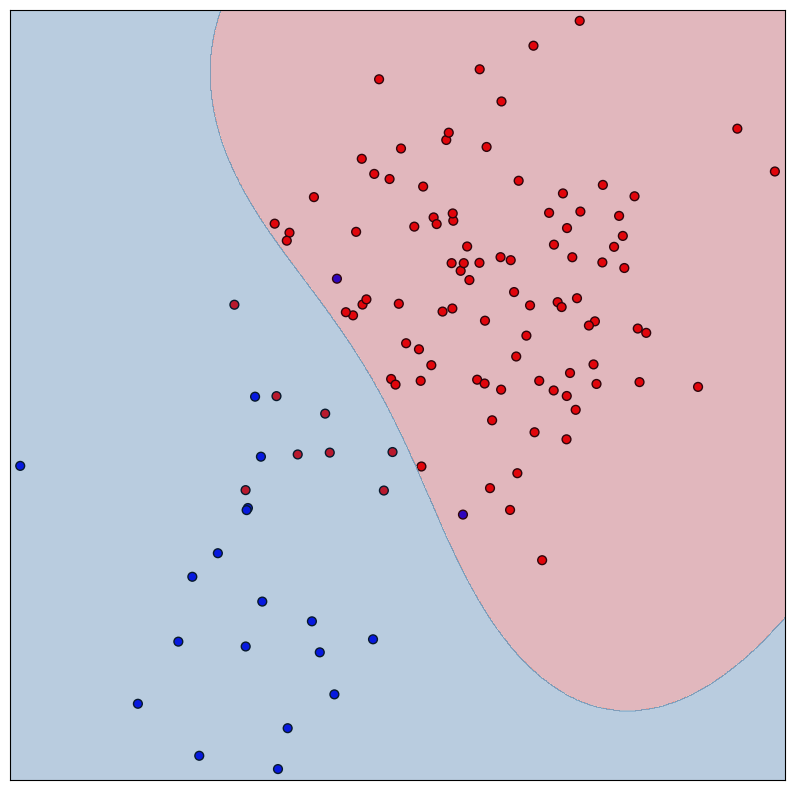

In [ ]:
# Модель с дефолтными параметрами, которую Вам предстоит улучшить
base_model = SVC()
base_model.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, base_model)

-----------
<font color="white" style="opacity:0.2023"></font>

Так как синих объектов было существенно больше в обучении, разделяющая поверхность отнесла к этому классу большую часть пространства около границы классов. При этом, из-за возросшего количества красных объектов в тестовой выборке, многие из них стали ошибочно относиться к другому классу.

Один из способов исправить эту проблему - это повлиять на форму поверхности с помощью задания весов классов, которые задаются через параметр class_weight в sklearn.svm.SVC. Особенно это может быть полезно в задачах, где известно, что распределение классов в обучающей выборке отличается от реального.
    
В данном задании вам будет дана выборка с несбалансированными данными. Кроме того, дана вторая выборка,
в которой классы имеют то же распределение, но классы имеют другое соотношение.  **Вам нужно построить различные rbf-модели, меняя параметры весов классов и визуализировать разделяющие поверхности. Попробуйте улучшить
качество на второй выборке (X_distr2, y_distr2), обучаясь только на первой (X_distr1, y_distr1) меняя параметры весов классов относительно дефолтных: class_weight={1: 1.0, 0: 1.0}. В качестве метрики, которую нужно оптимизировать нужно использовать accuracy на (X_distr2, y_dist2).**

In [ ]:
from itertools import product

In [ ]:
w1_best, w2_best = None, None
best_acc = None
grid = [0.01, 0.1, 0.5, 1.0, 5, 10, 100, 1000]
for w1, w2 in product(grid, grid):
    svc_cls = SVC(C=1.0, class_weight={1: w1, 0: w2})
    svc_cls.fit(X_distr1, y_distr1)
    acc = accuracy_score(y_distr2, svc_cls.predict(X_distr2))
    # Save model with best accuracy
    if best_acc is None or acc > best_acc:
        best_acc, w1_best, w2_best = acc, w1, w2


print(f'Weight1: {w1_best},\nWeight2: {w2_best},\nBest accuracy: {best_acc}')

Weight1: 0.1,
Weight2: 5,
Best accuracy: 0.9666666666666667


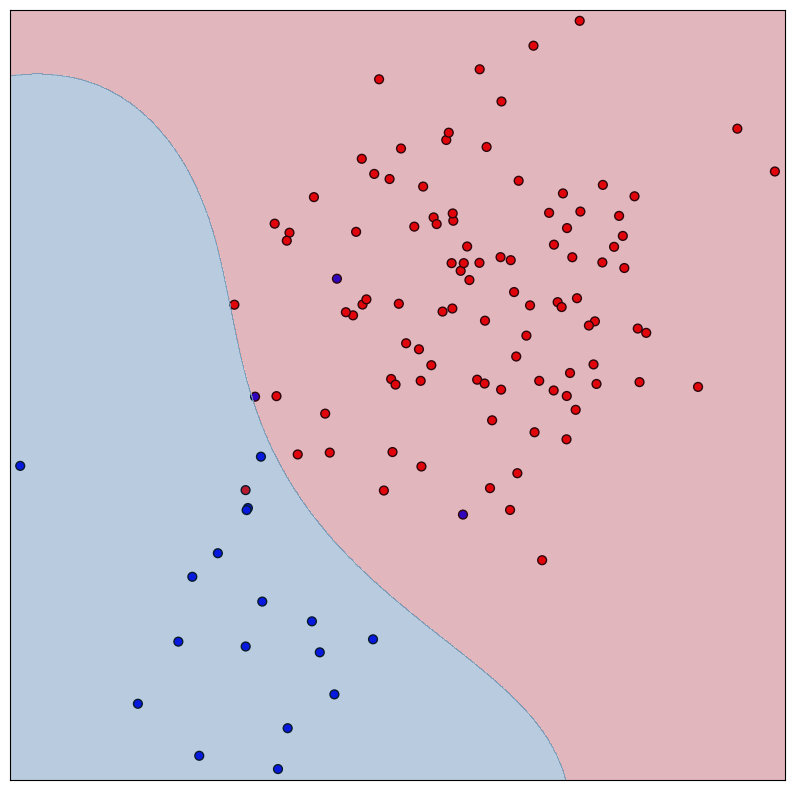

In [ ]:
best_svc_cls = SVC(C=1.0, class_weight={1: w1_best, 0: w2_best})
best_svc_cls.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, best_svc_cls)

In [ ]:
print('My best classifier:')
print('Accuracy:', accuracy_score(y_distr2, best_svc_cls.predict(X_distr2)))

My best classifier:
Accuracy: 0.9666666666666667


# 4. Обучите лучшую SVM модель (ML-решение)

Возможность строить нелинейные поверхности может сильно улучшить качество, но и несет риск переобучения.
    В этом задании предстоит обучить лучшую svm модель и получить хорошее качество на тесте в системе тестирования. Для контроля переобучения рекомендуется пользоваться кросс-валидацией. Для улучшения качества рекомендуется подбирать

1. параметр регуляризации C;
2. тип разделяющей кривой linear/rbf/poly;
3. степень в случае разделяющей кривой poly.

Также не забывайте, что при решении задач машинного обучения полезно смотреть в данные :)

Все csv-таблицы с данными вы можете взять из публичного теста, который также есть в проверяющей системе. Для этого распакуйте архив с публичными тестами и положите файлы в рабочей директории (рядом с ноутбуком)

In [ ]:
X_train = np.load('public/cX_train.npy')
y_train = np.load('public/cy_train.npy')
X_test = np.load('public/cX_test.npy')

In [ ]:
X_train.shape, y_train.shape, X_test.shape

((800, 5), (800,), (200, 5))

In [ ]:
X = X_train
y = y_train.ravel()

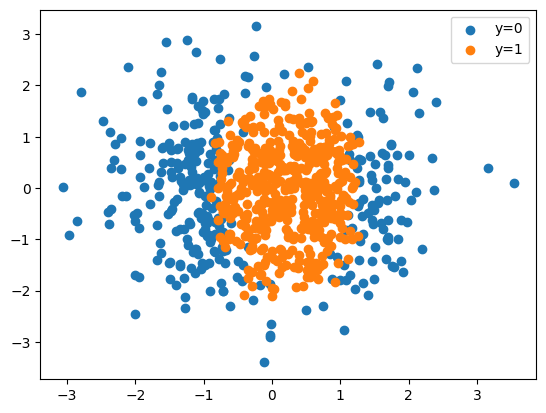

In [ ]:
plt.scatter(X[y == 0, 4], X[y == 0, 3], label='y=0')
plt.scatter(X[y == 1, 4], X[y == 1, 3], label='y=1')
plt.legend()

**Отправьте код обучения модели с оптимальными параметрами в проверяющую систему, воспользовавшись приложенным шаблоном svm_solution.py. Кросс-валидацию параметров в посылаемом решении делать <font color='red'>не нужно</font> -- достаточно подобрать, например, их тут, а в решении уже обучать модель с оптимальными параметрами.**

# 4. Влияние гиперпараметров (4 балла)

В предыдущей части Вы обучили хорошую SVM модель, подбирая гиперпараметры модели. Давайте теперь попробуем обучить логистическую регрессию на этой же выборке, и по кросс-валидации оценить влияние гиперпараметров на линейную модель.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
c_seq = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]

for i, C in enumerate(c_seq):
    lin_model = LogisticRegression(solver='liblinear', C=C)
    score = cross_val_score(lin_model, X, y)
    print("C =", C, "score =", score.mean())

C = 1e-06 score = 0.78625
C = 1e-05 score = 0.78625
C = 0.0001 score = 0.78625
C = 0.001 score = 0.7825
C = 0.01 score = 0.78125
C = 0.1 score = 0.78125
C = 1 score = 0.78125
C = 10 score = 0.78
C = 100 score = 0.78
C = 1000 score = 0.78
C = 10000 score = 0.78
C = 100000 score = 0.78
C = 1000000 score = 0.78
C = 10000000 score = 0.78


In [ ]:
for i, C in enumerate(c_seq):
    lin_model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    score = cross_val_score(lin_model, X, y)
    print("C =", C, "score =", score.mean())

C = 1e-06 score = 0.39749999999999996
C = 1e-05 score = 0.39749999999999996
C = 0.0001 score = 0.39749999999999996
C = 0.001 score = 0.39749999999999996
C = 0.01 score = 0.39749999999999996
C = 0.1 score = 0.8024999999999999
C = 1 score = 0.78625
C = 10 score = 0.78125
C = 100 score = 0.78
C = 1000 score = 0.78
C = 10000 score = 0.78
C = 100000 score = 0.78
C = 1000000 score = 0.78
C = 10000000 score = 0.78


In [ ]:
for i, C in enumerate(c_seq):
    lin_model = LogisticRegression(penalty='l2', solver='liblinear', C=C)
    score = cross_val_score(lin_model, X, y)
    print("C =", C, "score =", score.mean())

C = 1e-06 score = 0.78625
C = 1e-05 score = 0.78625
C = 0.0001 score = 0.78625
C = 0.001 score = 0.7825
C = 0.01 score = 0.78125
C = 0.1 score = 0.78125
C = 1 score = 0.78125
C = 10 score = 0.78
C = 100 score = 0.78
C = 1000 score = 0.78
C = 10000 score = 0.78
C = 100000 score = 0.78
C = 1000000 score = 0.78
C = 10000000 score = 0.78


Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

**Вывод:**
Выбор гиперпараметров является ключевым моментом в процессе обучения моделей SVM. Для линейных моделей, как видим, слабо влиял выбор гиперпараметров (мы попробовали разные типы регуляризации с разным коэффициентом регуляризации - результат почти никак не менялся). А вот подбор гиперпараметров SVM в прошлой части очень сильно повлияло на качество разделеления классов (например, подбор ядра или весов).

# 5. Ограничения SVM (3 балла)

В предыдущих заданиях мы убедились в мощности и гибкости моделей SVM. Теперь ответим на вопрос, насколько реально обучить модель SVM на выборках большого размера или с большим числом признаков.
    
   Нужно провести два эксперимента. В первом перебирать размер выборки
    и для каждого запуска посчитать реальное время обучения модели. При этом
    делить выборку на обучение и тестирование не нужно. Также качество обученной модели в данном эксперименте не имеет значение. Размеры выборки предлагается перебирать в диапазоне range(1000, 10001, 1000) с использованием generate_data_with_balanced_classes(size=n).
    
   Необходимо сравнить время обучения SVM с логистической регрессией. Для этого
    замеры повторите также для модели sklearn.linear_model.LogisticRegression. Время обучения одной модели замеряйте
    с помощью стандартной библиотеки time (пример в ячейке ниже).
    
Вы можете поставить эксперименты и с большими выборками, чем предлагается в задании (сгенерировать их),  
тогда эффект должен быть виден еще сильнее.

**Внимание!** во время замеров времени работы, отключите сторонние процессы, занимающие CPU, иначе замеры времени работы окажутся некорректными. Помните, что времени работы в зависимости от числа данных и признаков должно меняться монотонно, без ступенчатых изменений (за исключением небольшого шума).

In [ ]:
# Как замерять время
import time
time_start = time.time()
time.sleep(1) # Вместо этой команды - запуск замеряемого алгоритма
print("Время работы:", time.time() - time_start)

Время работы: 1.0009737014770508


In [ ]:
def generate_data_with_balanced_classes(size=500, d=2, noise_scale=0.1):
    X = np.random.normal(size=(size*2, d))
    mask = X[:, 1] ** 2 > X[:, 0] - 0.1 + np.random.normal(scale=noise_scale)
    y = np.ones(len(X))
    y[mask] = 0
    return X, y

In [ ]:
svc_fit_time, logreg_fit_time = [], []

for n in range(1000, 10001, 1000):
    X, y = generate_data_with_balanced_classes(size=n)
    svc_model = SVC()
    time_start = time.time()
    svc_model.fit(X, y)
    svc_cur_time = time.time() - time_start
    svc_fit_time.append(svc_cur_time)
    logreg_model = LogisticRegression()
    time_start = time.time()
    logreg_model.fit(X, y)
    logreg_cur_time = time.time() - time_start
    logreg_fit_time.append(logreg_cur_time)
    print("n:", n)
    print(f"SVC fit time: {svc_cur_time:.5f}")
    print(f"Logistic regression fit time: {logreg_cur_time:.5f}")

n: 1000
SVC fit time: 0.02301
Logistic regression fit time: 0.00400
n: 2000
SVC fit time: 0.06001
Logistic regression fit time: 0.00601
n: 3000
SVC fit time: 0.10303
Logistic regression fit time: 0.00899
n: 4000
SVC fit time: 0.18404
Logistic regression fit time: 0.00966
n: 5000
SVC fit time: 0.25605
Logistic regression fit time: 0.01219
n: 6000
SVC fit time: 0.30906
Logistic regression fit time: 0.01300
n: 7000
SVC fit time: 0.41911
Logistic regression fit time: 0.01639
n: 8000
SVC fit time: 0.53512
Logistic regression fit time: 0.01400
n: 9000
SVC fit time: 0.67014
Logistic regression fit time: 0.01628
n: 10000
SVC fit time: 0.70916
Logistic regression fit time: 0.01700


Во втором эксперименте предлагается проделать то же самое, что и в первом эксперименте, только меняя размерность пространства признаков.
    Для этого можете воспользоваться функцией generate_data_with_balanced_classes(dim=d). Признаки предлагается перебирать по сетке $range(10, 1001, 100)$.

In [ ]:
for d in range(10, 1001, 100):
    X, y = generate_data_with_balanced_classes(d=d)
    svc_model = SVC()
    time_start = time.time()
    svc_model.fit(X, y)
    svc_cur_time = time.time() - time_start
    logreg_model = LogisticRegression()
    time_start = time.time()
    logreg_model.fit(X, y)
    logreg_cur_time = time.time() - time_start
    print("d:", d)
    print(f"SVC fit time: {svc_cur_time:.5f}")
    print(f"Logistic regression fit time: {logreg_cur_time:.5f}")

d: 10
SVC fit time: 0.02701
Logistic regression fit time: 0.00900
d: 110
SVC fit time: 0.06903
Logistic regression fit time: 0.00899
d: 210
SVC fit time: 0.09704
Logistic regression fit time: 0.01999
d: 310
SVC fit time: 0.12504
Logistic regression fit time: 0.02299
d: 410
SVC fit time: 0.14602
Logistic regression fit time: 0.03342
d: 510
SVC fit time: 0.17503
Logistic regression fit time: 0.03201
d: 610
SVC fit time: 0.17904
Logistic regression fit time: 0.03902
d: 710
SVC fit time: 0.21405
Logistic regression fit time: 0.03899
d: 810
SVC fit time: 0.22205
Logistic regression fit time: 0.03201
d: 910
SVC fit time: 0.26407
Logistic regression fit time: 0.03701


Постройте графики времени работы в зависимости от числа объектов для SVM и логистической регрессии, сравните их и сделайте выводы.
    
Придумывая обоснование получившимся результатам попробуйте использовать
    вид решаемой задачи в SVM, который был дан вам на лекции.

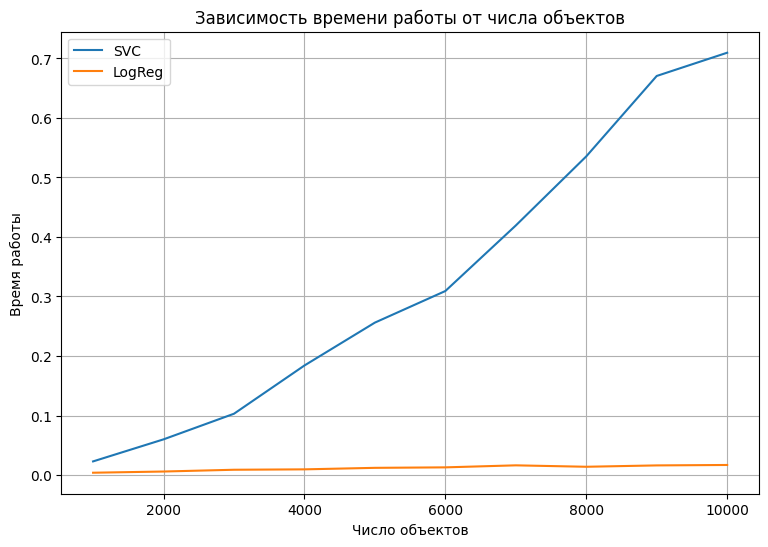

In [ ]:
plt.figure(figsize=(9, 6))
plt.title("Зависимость времени работы от числа объектов")
plt.grid(True)
plt.xlabel("Число объектов")
plt.ylabel("Время работы")
plt.plot(list(range(1000, 10001, 1000)), svc_fit_time, label="SVC")
plt.plot(list(range(1000, 10001, 1000)), logreg_fit_time, label="LogReg")
plt.legend()
plt.show()

**Вывод:** Из результатов эксперимента и графика видно, что время обучения модели SVM увеличивается в сравнении с логистической регрессии.

В случае с SVM мы используем ядро RBF, которое определяется как $K(x, z) = e^{-\gamma ||x - z||^2}, \gamma > 0.$ Как видим, сложность обучения растёт квадратично с увеличением числа объектов.

Логистическая регрессия показывает более линейный рост времени обучения в зависимости от числа признаков, что свидетельствует о её относительной масштабируемости по сравнению с SVM. При выборе между SVM и логистической регрессией необходимо учитывать не только время обучения, но и качество модели. Если время является критическим фактором, логистическая регрессия может быть лучшим выбором.

# 6. Уменьшение размерности входа (4 балла)

Если уменьшение числа объектов сложная и зачастую невозможная задача, то
    для понижения числа признаков существует стандартное решение. В предыдущих заданиях Вы уже сталкивались с l1-регуляризацией, которая позволяла уменьшить число признаков в задаче линейной классификации/регрессии. Однако для большинства ML-алгоритмов такой способ уменьшения числа признаков неприменим.
    
   Зато существует стандартное для всех алгоритмов понижение размерности входа. Данный алгоритм называется Principal Component Analysis (PCA, метод главных компонент). Он находит такое линейное пространство меньшей размерности $k$ ($k << d$, где d изначальная размерность входа), проекция на которое теряет меньше всего информации. Подробнее об этом можете почитать тут https://scikit-learn.org/stable/modules/decomposition.html#pca.
    
   **Эксперимент:** Проекция в очень малое число координат сильно "упрощает" выборку, из-за чего качество решения задачи может в итоге упасть. **В следующем эксперименте предлагается исследовать зависимость скорости работы метода и качества решения задачи при использовании понижения размерности. Требуется построить два графика:**

1. График зависимости времени работы всего цикла обучения от числа признаков $k$, которое остается после применения PCA.
2. График зависимости качества решения (accuracy) задачи классификации от числа признаков $k$, которое остается после применения PCA.
    
При этом под полным циклом обучения подразумевается обучение PCA + обучение SVM. Данные для обучения: первые две координаты - луны, которые были в первом задании, а остальные координаты, случайные.
Таким образом, без понижения размерности SVM с rbf ядром должен иметь точность близкую к 100\%. Чтобы лучше
видеть эффект на графиках, можете менять размер генерируемой выборки. Для данных размеров $k$ рекомендуется перебирать от 10 до 500 (тогда будет видна требуемая закономерность).
    
   **P.S. Не забывайте делить выборку на обучение и валидацию в этом эксперименте** (так как мы смотрим на качество, мы хотим считать его честно). При этом PCA как и любой другой алгоритм ML тоже нельзя учить на тесте. Общая схема применения PCA описана в ячейках ниже.

In [ ]:
X_moons, y_moons = make_moons_cls(2000, 1000)

In [ ]:
X_moons.shape

(2000, 1000)

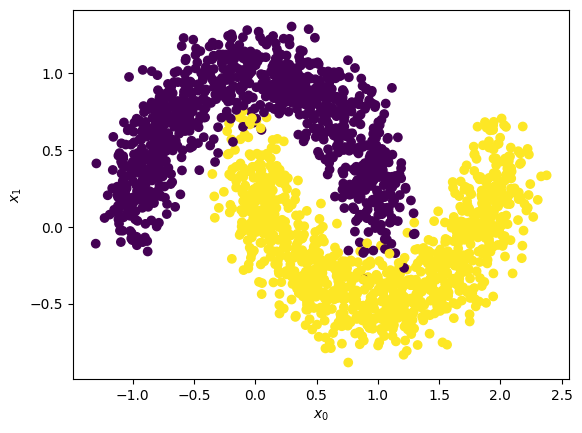

In [ ]:
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.show()

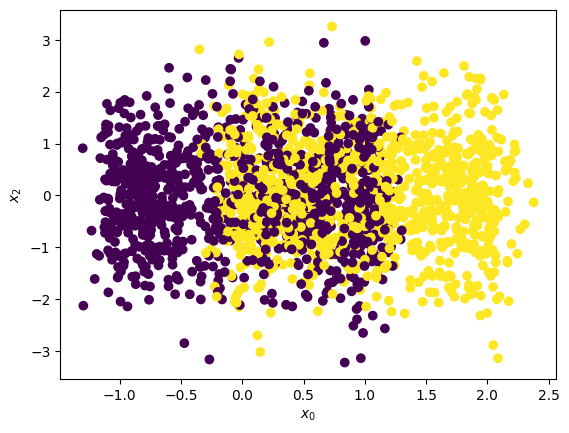

In [ ]:
plt.scatter(X_moons[:, 0], X_moons[:, 2], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.show()

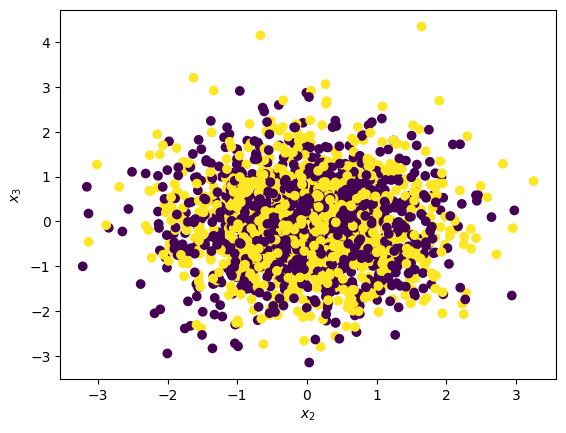

In [ ]:
plt.scatter(X_moons[:, 2], X_moons[:, 3], c=y_moons)
plt.xlabel('$x_2$')
plt.ylabel('$x_3$')
plt.show()

Казалось бы понизить размерность в этой задаче достаточно легко, нужно просто выбрать только первые две координаты. Однако из-за нелинейности разделяющей поверхности, для PCA это задача нетривиальна. Такая же ситуация наблюдается и в большинстве прикладных задач. Теперь переходите **к эксперименту** :)

In [ ]:
# Пример правильного обучения PCA с делением на train/test
time_list, accuracy_list = [], []
for i in range(10, 501, 5):
    pca_model = PCA(n_components=i)

    X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
        X_moons, y_moons, test_size=0.2) # делим выборку на трейн тест для оценки качества всего алгоритма

    X_train_for_pca, X_train_for_svc, y_train_for_pca, y_train_for_svc = train_test_split(
        X_moons_train, y_moons_train, test_size=0.5) # делим выборку на трейн тест для оценки качества всего алгоритма

    # Учим PCA
    time_start = time.time()
    pca_model.fit(X_train_for_pca)
    time_pca = time.time() - time_start

    # Применяем PCA
    X_moons_test_transformed = pca_model.transform(X_moons_test)
    X_train_for_svc_transformed = pca_model.transform(X_train_for_svc)

    # Учим SVC (на другой выборке чтобы не переобучиться)
    svc_on_transformed = SVC(kernel='rbf')
    time_start = time.time()
    svc_on_transformed.fit(X_train_for_svc_transformed, y_train_for_svc)
    time_svc = time.time() - time_start

    preds = svc_on_transformed.predict(X_moons_test_transformed)

    time_list.append(time_pca + time_svc)
    accuracy_list.append(accuracy_score(preds, y_moons_test))

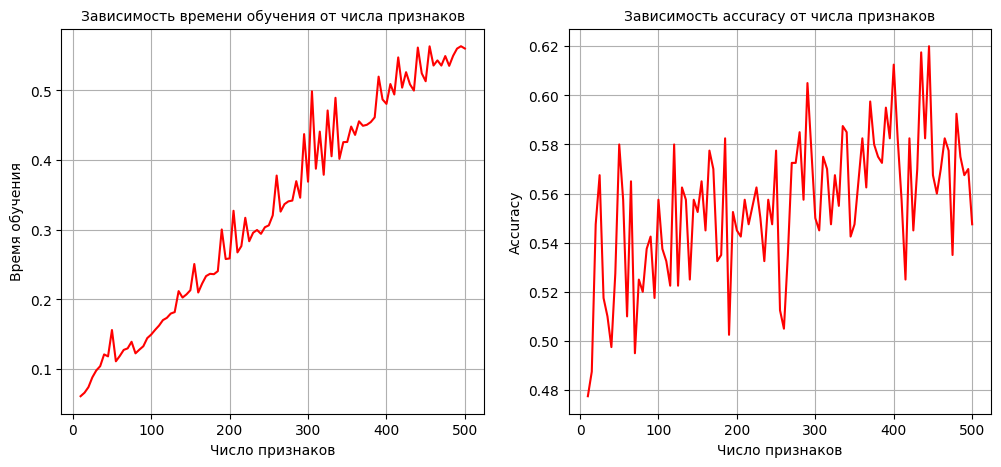

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Зависимость времени обучения от числа признаков", fontsize=10)
plt.grid(True)
plt.xlabel("Число признаков")
plt.ylabel("Время обучения")
plt.plot(list(range(10, 501, 5)), time_list, color='red')

plt.subplot(1, 2, 2)
plt.title("Зависимость accuracy от числа признаков", fontsize=10)
plt.grid(True)
plt.xlabel("Число признаков")
plt.ylabel("Accuracy")
plt.plot(list(range(10, 501, 5)), accuracy_list, color='red')

plt.show()

Опишите в выводе как ведет себя качество решения задачи и время работы в зависимости от числа компонент в PCA.  

**Вывод:** Время обучения с увеличением числа признаков растёт, что вполне ожидаемо, так как требуется большее число ресурсов для обучения.
Качество решения хоть и колеблется, но видно, что с уменьшением числа признаков accuracy падает.

# 7. Калибровка вероятностей (3 балла)

Иногда в задаче классификации важно знать уверенность отнесения к тому или иному классу. В SVM за это отвечает параметр отступа (margin), который можно посчитать, используя model.decision_function(X). Именно отступ до разделяющей кривой пытается максимизироавть модель во время обучения. Однако по нему сложно утверждать с какой вероятностью объект относится к тому или иному классу.

Чтобы это понять давайте построим следующую кривую:
1) нормализуем отступы так, чтобы они лежали в диапазоне от 0 до 1;

2) разделим все объекты на бины по нормализованному оступу (например на [0, 0.1), [0.1, 0.2)...);

3) для каждого бина построим точку с координатой x - равной среднему значению нормализованного оступа внутри бина, и с координатой y - равной доле объектов класса 1 внутри бина.

Заметим теперь, что если бы нормализованный отступ приблизительно равнялся вероятности отнесения к классу, то бину [x, x + 0.1) должна была бы соответствовать точка с координатой Х принадлежащей [x, x + 0.1) и координатой Y в том же диапазоне. Таким образом, чем лучше скоры модели показывают вероятность отнесения к классу 1, тем больше калибровочная кривая похожа на прямую из точки (0, 0) в (1, 1).

Кроме того построим аналогично кривую для логистической регрессии, взяв вместо нормализованного отступа - вероятность отнесения к первому классу через predict_proba. Так как логистическая регрессия оптимизирует LogLoss и её выходом уже являются вероятности отнесения к классам, будем ожидать что её кривая хорошо ляжет на прямую из (0, 0) в (1, 1).

In [ ]:
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

c:\Users\777\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
c:\Users\777\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


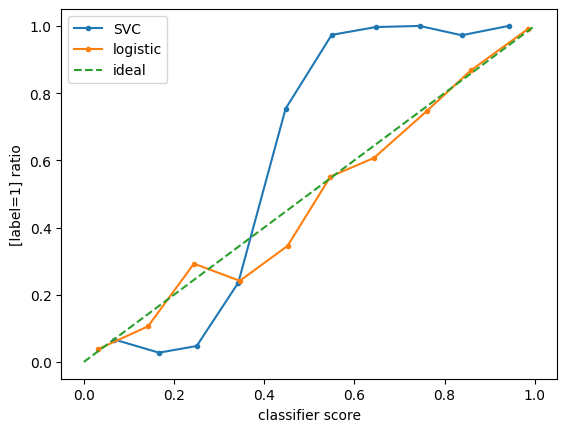

In [ ]:
# generate 2 class dataset
X, y = make_classification(n_samples=5000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = SVC()
model.fit(trainX, trainy)
# predict probabilities
probs = model.decision_function(testX)

# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
# plot model reliability
plt.plot(mpv, fop, marker='.', label='SVC')
plt.xlabel('classifier score')
plt.ylabel('[label=1] ratio')

logistic_model = LogisticRegression()
logistic_model.fit(trainX, trainy)

logistic_probs = logistic_model.predict_proba(testX)[:, 1]

# reliability diagram
log_fop, log_mpv = calibration_curve(testy, logistic_probs, n_bins=10, normalize=True)
# plot perfectly calibrated
# plot model reliability
plt.plot(log_mpv, log_fop, marker='.', label='logistic')
plt.plot([0, 1], [0, 1], linestyle='--', label='ideal')
plt.legend()
plt.show()

-----------
<font color="white" style="opacity:0.2023"></font>

Вот мы и увидели проблему, линия отступов не ложится на пунктирную линию, что означает что оступы не соотвествуют реальным вероятностям отнесения к тому или иному классу.  

   Но не всё пропало! Из отступов всё ещё можно получить вероятность отнесения к классу. Для этого существует  такая процедура как калибровка вероятностей, при которой отступ для каждого объекта преобразовывается таким образом, чтобы соответствовать вероятности класса. После такого преобразования, полученное число становится интерпретируемой мерой уверенности модели.

В данном задании Вам прелагается обучить логистическую регрессию на отступах модели, которая по оступу (margin) предсказывала бы класс. Именно вероятности этой калибровочной модели и будут нашими верными оценками вероятности класса для объекта:

$p(y_i | x_i) = p(y_i | margin_i)$

Для этого Вам потребуется написать несложный класс CalibratingLogisticRegression. И проверить что новые предсказания дают правильную калибровочную кривую

In [ ]:
class CalibratingLogisticRegression:
    def fit(self, x, y):
        assert len(x.shape) == 1 or x.shape[1] == 1
        x = np.array(x).reshape(-1, 1)
        self.model = LogisticRegression()
        self.model.fit(x, y)

    def predict_proba(self, x):
        assert len(x.shape) == 1 or x.shape[1] == 1
        x = np.array(x).reshape(-1, 1)

        return self.model.predict_proba(x)

Калибровочную модель и исходную модель нельзя учить на одних и тех же данных, чтобы избежать переобучения. (распределение отступов на обучении и тестовой выборке, скорее всего очень сильно отличается)

In [ ]:
model = SVC()
N = len(trainX) // 2
model.fit(trainX[:N], trainy[:N])

SVC()

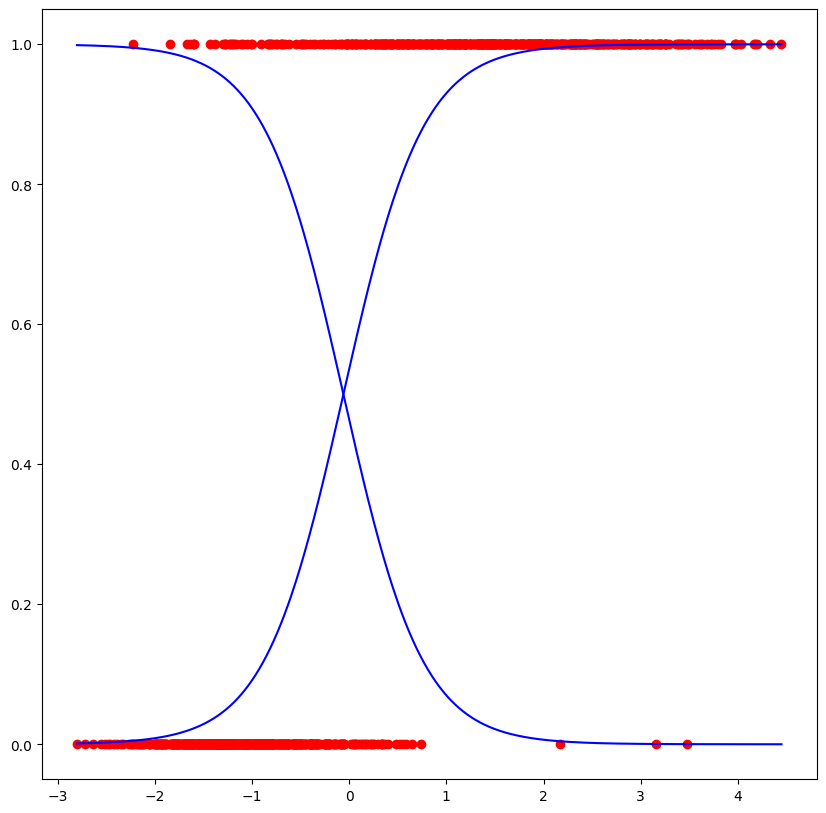

In [ ]:
margin = model.decision_function(trainX[N:])


# Учим калибровочную модель на второй половине данных
calibrating_model = CalibratingLogisticRegression()
calibrating_model.fit(margin, trainy[N:])
prob = calibrating_model.predict_proba(margin)


# Как это выглядит на обучении
margin_sorted, probs_sorted_by_margin = zip(*sorted(zip(margin, prob)))
plt.figure(figsize=(10, 10))
plt.plot(margin, trainy[N:], 'ro')
plt.plot(margin_sorted, probs_sorted_by_margin, 'b')
plt.show()

c:\Users\777\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


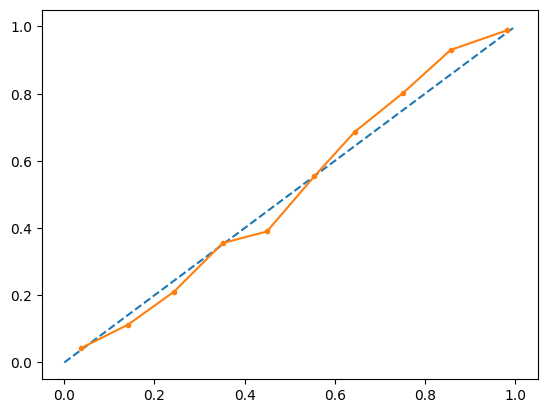

In [ ]:
probs = calibrating_model.predict_proba(model.decision_function(testX))
# reliability diagram
fop, mpv = calibration_curve(testy, probs[:, 1], n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Обратите внимание, что кривая для откалиброванных отступов должня также строиться для бинов и состоянть из n_bins точек. Если у Вас получилось кривая из трёх точек, Вы что-то сделали неправильно :)

**Сделайте выводы** о полученной модели. В каких задачах калибровка вероятностей могла бы быть полезной?

**Выводы:** Результаты показывают, что модель хорошо откалибрована, поскольку кривая близка к идеальной линии. Это означает, что предсказанные вероятности модели коррелируют с реальными вероятностями.

Калибровка вероятностей может быть особенно полезной в следующих задачах:

1. **Клинические испытания или медицинские прогнозы**: Точные вероятности могут быть критически важны при оценке риска заболевания или прогнозировании исхода болезни.

2. **Кредитный скоринг**: В банковском деле калиброванные вероятности помогают оценить риск невозврата кредита и устанавливать цены на страхование.

3. **Прогнозирование оттока клиентов**: Предсказание вероятности того, что клиент уйдет, может помочь бизнесу разработать стратегии удержания.

4. **Погодные прогнозы**: Предсказание вероятностей определенных погодных условий может быть полезным для планирования и оперативных решений.

5. **Системы рекомендаций**: Калиброванные вероятности могут улучшить качество рекомендаций, например, в электронной коммерции или стриминговых сервисах.

# Бонусное задание (2 балла)

Найдите мем про SVM лучше чем этот:

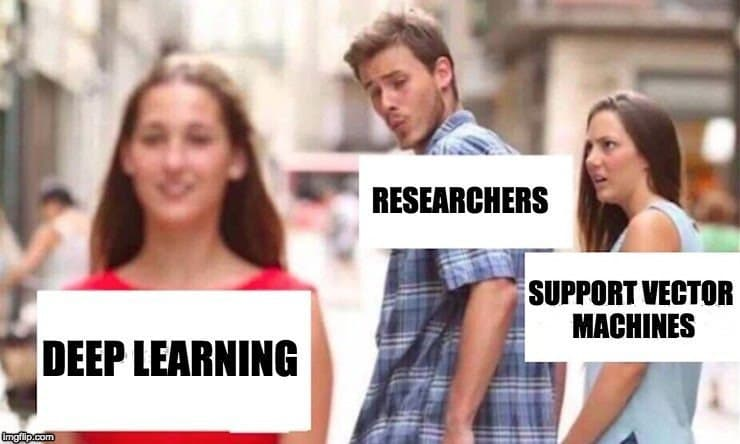

Важно: самый простой способ вставить картинку будет через Google Colab (даже если вы изначально делали не в нем). Нажмите на **"+ Text"**, в появившейся ячейке сделайте **прикрепление картинки** (как на скринах). Тогда ваша картинка "зашифруется" и будет корректно отображаться при конвертации в html

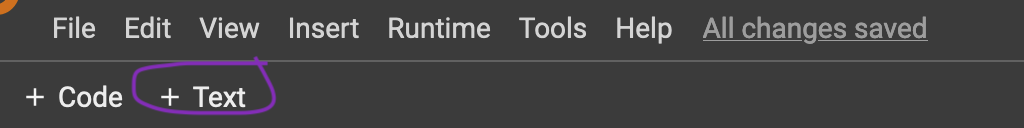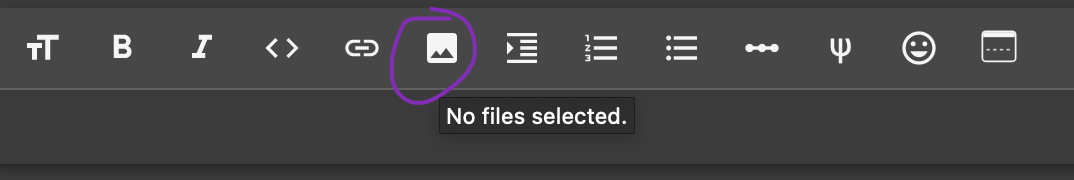

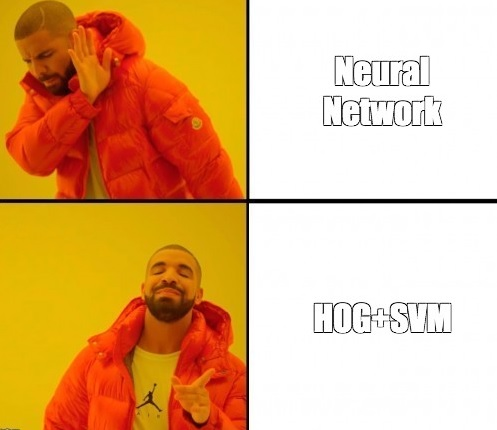